In [1]:
import requests
import zipfile
from pathlib import Path

In [2]:
!pip install tqdm

In [3]:
from tqdm import tqdm

In [4]:
# Setup path to data folder
data_path = Path("data/")

# Download and extract the dataset
def download_data(url: str, dest: Path):
    dest.mkdir(parents=True, exist_ok=True)
    
    dataset_folder = dest / "ISIC2018_Task3_Training_Input"
    if dataset_folder.exists() and dataset_folder.is_dir():
        print("Dataset already exists. Skipping download.")
        return
    
    try:
        # Stream the download to handle large files
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))
            zip_path = dest / "dataset.zip"
            
            with open(zip_path, "wb") as f, tqdm(
                desc="Downloading",
                total=total_size,
                unit="B",
                unit_scale=True,
                unit_divisor=1024,
            ) as progress_bar:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
                    progress_bar.update(len(chunk))
            
        # Unzip the file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest)
        
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting the zip file: {e}")
    finally:
        if zip_path.exists():
            zip_path.unlink()


download_data("https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip", data_path)
# Verify the dataset folder exists and print its contents
dataset_folder = data_path / "ISIC2018_Task3_Training_Input"
if dataset_folder.exists() and dataset_folder.is_dir():
    print(f"Dataset folder '{dataset_folder}' exists. Contents ({len(list(dataset_folder.iterdir()))} items):")
else:
    print(f"Dataset folder '{dataset_folder}' does not exist.")


Dataset already exists. Skipping download.
Dataset folder 'data/ISIC2018_Task3_Training_Input' exists. Contents (10017 items):


In [5]:
# Exploratory Data Analysis of HAM10000 Skin Lesion Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
import glob
from PIL import Image as Img
import matplotlib.image as mpimg
from IPython.display import Image

In [6]:
# Set style for visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [7]:
print("1. Loading HAM10000 dataset")
# Path to metadata file
metadata_path = "data/HAM10000_metadata.csv"
# Load metadata
metadata_df = pd.read_csv(metadata_path)

1. Loading HAM10000 dataset


In [8]:
# Display basic information
print("\n2. Basic Dataset Information")
print(f"Number of images: {metadata_df.shape[0]}")
print(f"Number of features: {metadata_df.shape[1]}")
print("\nFirst few rows of the dataset:")
print(metadata_df.head())


2. Basic Dataset Information
Number of images: 10015
Number of features: 8

First few rows of the dataset:
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


In [9]:
# Display column information
print("\nDataset columns:")
print(metadata_df.columns.tolist())


Dataset columns:
['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset']


In [10]:
# 3. Data types and missing values
print("\n3. Data Types and Missing Values:")
print(metadata_df.info())
print("\nMissing values per column:")
print(metadata_df.isnull().sum())


3. Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB
None

Missing values per column:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64


In [11]:
# 4. Statistical summary
print("\n4. Statistical Summary:")
print(metadata_df.describe(include='all'))


4. Statistical Summary:
          lesion_id      image_id     dx dx_type          age    sex  \
count         10015         10015  10015   10015  9958.000000  10015   
unique         7470         10015      7       4          NaN      3   
top     HAM_0000835  ISIC_0032258     nv   histo          NaN   male   
freq              6             1   6705    5340          NaN   5406   
mean            NaN           NaN    NaN     NaN    51.863828    NaN   
std             NaN           NaN    NaN     NaN    16.968614    NaN   
min             NaN           NaN    NaN     NaN     0.000000    NaN   
25%             NaN           NaN    NaN     NaN    40.000000    NaN   
50%             NaN           NaN    NaN     NaN    50.000000    NaN   
75%             NaN           NaN    NaN     NaN    65.000000    NaN   
max             NaN           NaN    NaN     NaN    85.000000    NaN   

       localization        dataset  
count         10015          10015  
unique           15              4  

In [12]:
# 5. Target variable (diagnosis) analysis
print("\n5. Distribution of Diagnosis (Target Variable):")
diagnosis_counts = metadata_df['dx'].value_counts()
print(diagnosis_counts)


5. Distribution of Diagnosis (Target Variable):
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [13]:
# Map diagnosis codes to their full name
diagnosis_mapping = {
    'akiec': 'Actinic Keratoses and Intraepithelial Carcinoma',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis-like Lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi',
    'vasc': 'Vascular Lesions'
}

# Add full diagnosis name to the dataframe
metadata_df['diagnosis_name'] = metadata_df['dx'].map(diagnosis_mapping)

In [14]:
# Create a bar plot for diagnosis distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='dx', hue='dx', data=metadata_df, palette='viridis', legend=False)
plt.title('Distribution of Skin Lesion Diagnoses', fontsize=16)
plt.xlabel('Diagnosis Code', fontsize=14)
plt.ylabel('Count', fontsize=14)

#  Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                fontsize=12)

# Add a legend explaining the diagnosis codes
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [diagnosis_mapping[label] for label in labels], 
          title='Diagnosis', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.savefig('charts/diagnosis_distribution.png')
plt.close()


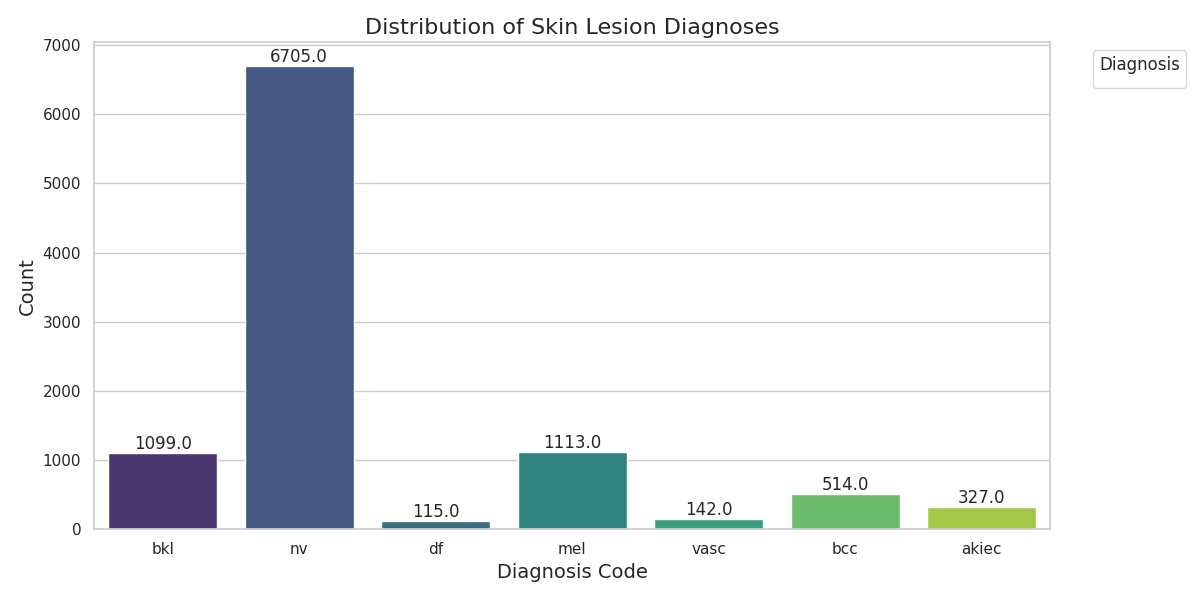

In [15]:
Image('charts/diagnosis_distribution.png')

In [16]:
# 6. Age distribution analysis
print("\n6. Age Distribution Analysis:")
print(f"Age range: {metadata_df['age'].min()} to {metadata_df['age'].max()} years")
print(f"Mean age: {metadata_df['age'].mean():.2f} years")
print(f"Median age: {metadata_df['age'].median()} years")


6. Age Distribution Analysis:
Age range: 0.0 to 85.0 years
Mean age: 51.86 years
Median age: 50.0 years


In [17]:
# Create age distribution histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=metadata_df, x='age', bins=20, kde=True)
plt.title('Age Distribution in HAM10000 Dataset', fontsize=16)
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.savefig('charts/age_distribution.png')
plt.close()

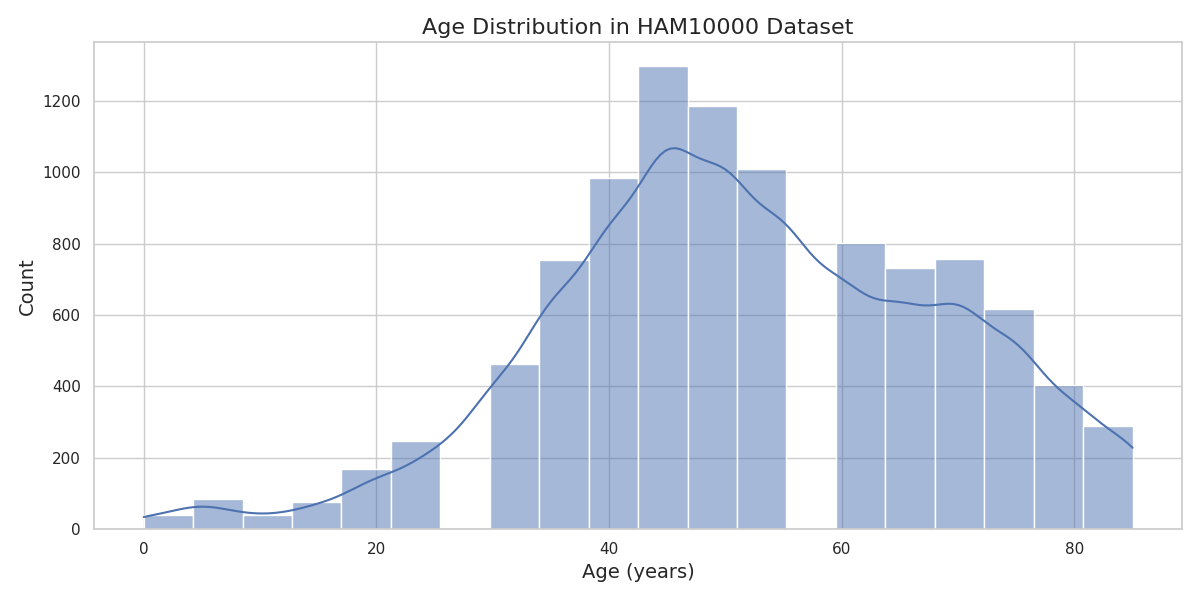

In [18]:
Image('charts/age_distribution.png')

In [19]:
# 7. Age distribution by diagnosis
plt.figure(figsize=(14, 8))
sns.boxplot(x='dx', y='age', data=metadata_df, palette='viridis')
plt.title('Age Distribution by Diagnosis', fontsize=16)
plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('Age (years)', fontsize=14)
plt.xticks(ticks=range(len(diagnosis_mapping)), labels=[f"{code} - {name}" for code, name in diagnosis_mapping.items()], rotation=45)
plt.tight_layout()
plt.savefig('charts/age_by_diagnosis.png')
plt.close()

/tmp/ipykernel_3248725/3058236631.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dx', y='age', data=metadata_df, palette='viridis')


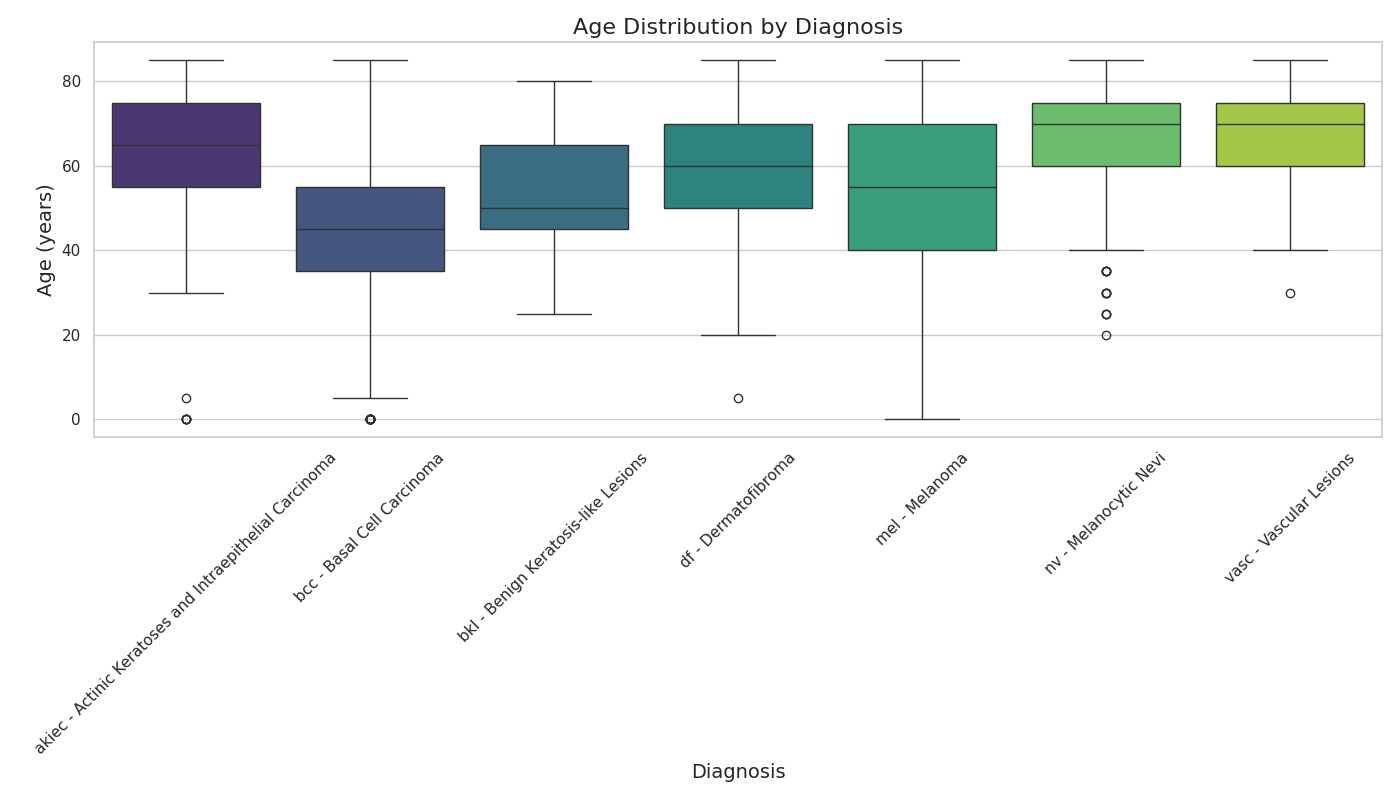

In [20]:
Image('charts/age_by_diagnosis.png')

In [21]:
# 8. Gender distribution
print("\n8. Gender Distribution:")
gender_counts = metadata_df['sex'].value_counts()
print(gender_counts)


8. Gender Distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


In [22]:
# Create gender distribution pie chart
plt.figure(figsize=(10, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', 
        colors=sns.color_palette('pastel'), startangle=90, explode=[0.05] * len(gender_counts)
)
plt.title('Gender Distribution', fontsize=16)
plt.tight_layout()
plt.savefig('charts/gender_distribution.png')
plt.close()

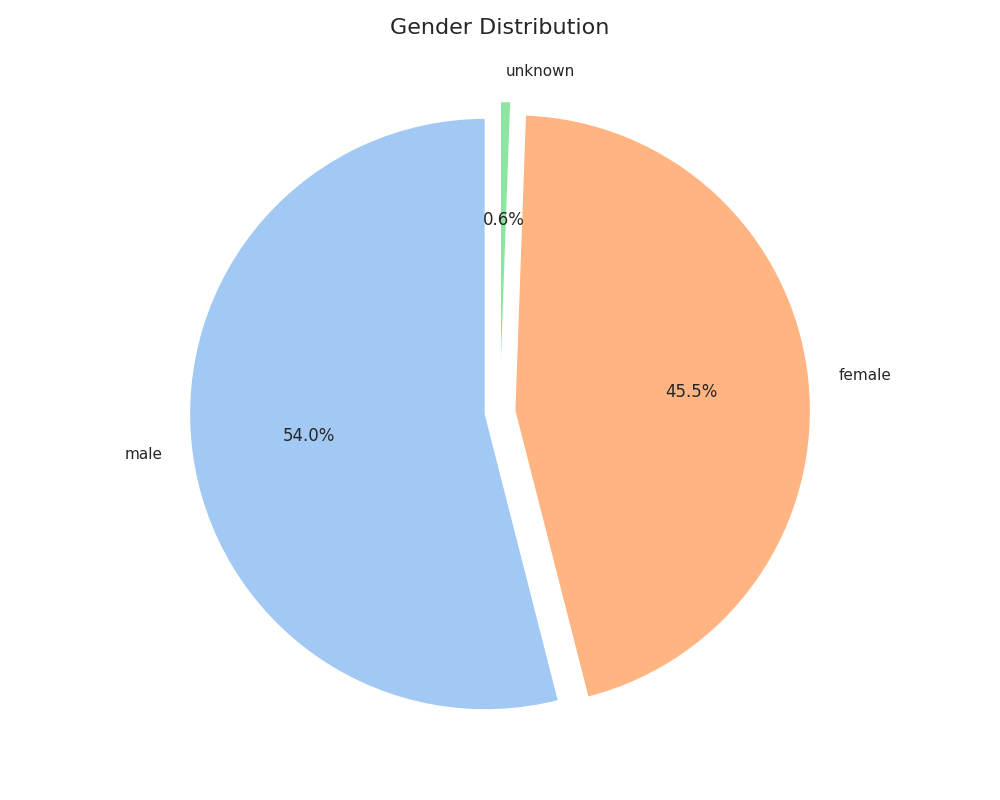

In [23]:
Image('charts/gender_distribution.png')

In [24]:
# 9. Gender distribution by diagnosis
gender_diagnosis = pd.crosstab(metadata_df['sex'], metadata_df['dx'])
gender_diagnosis_percentage = gender_diagnosis.div(gender_diagnosis.sum(axis=0), axis=1) * 100

plt.figure(figsize=(14, 8))
gender_diagnosis.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Gender Distribution by Diagnosis', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Diagnosis', labels=[f"{code} - {diagnosis_mapping[code]}" for code in gender_diagnosis.columns])
plt.tight_layout()
plt.savefig('charts/gender_by_diagnosis.png')
plt.close()

# show the image

<Figure size 1400x800 with 0 Axes>

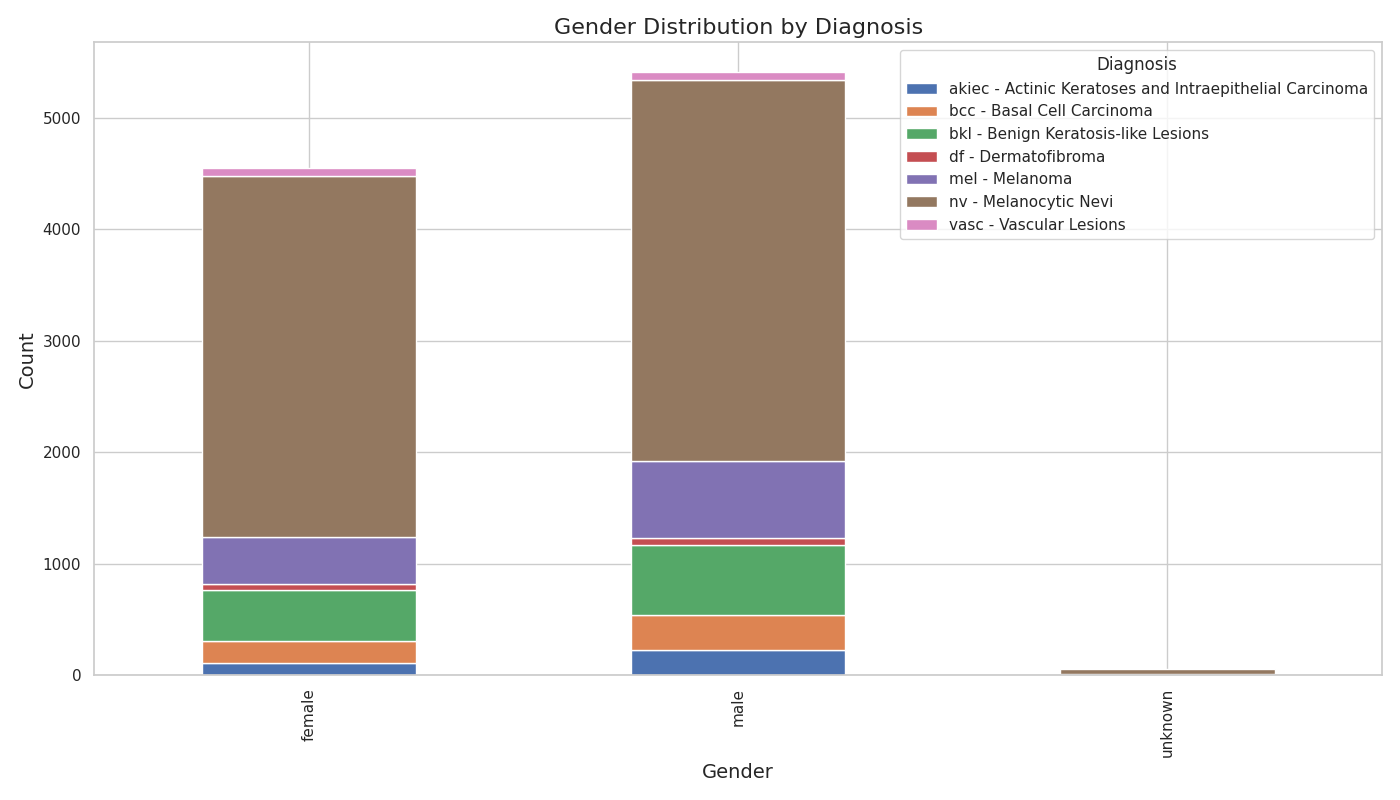

In [25]:
Image('charts/gender_by_diagnosis.png')

In [26]:
# 10. Localization of skin lesions
print("\n10. Localization of Skin Lesions:")
localization_counts = metadata_df['localization'].value_counts()
print(localization_counts)


10. Localization of Skin Lesions:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


In [27]:
# Create localization distribution bar chart
plt.figure(figsize=(14, 8))
ax = sns.countplot(y='localization', data=metadata_df, order=metadata_df['localization'].value_counts().index, palette='viridis')
plt.title('Distribution of Lesion Localization', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Body Site', fontsize=14)

# Add count labels
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 50, p.get_y() + p.get_height()/2, f'{width}', ha='left', va='center')

plt.tight_layout()
plt.savefig('charts/localization_distribution.png')
plt.close()

/tmp/ipykernel_3248725/905688198.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='localization', data=metadata_df, order=metadata_df['localization'].value_counts().index, palette='viridis')


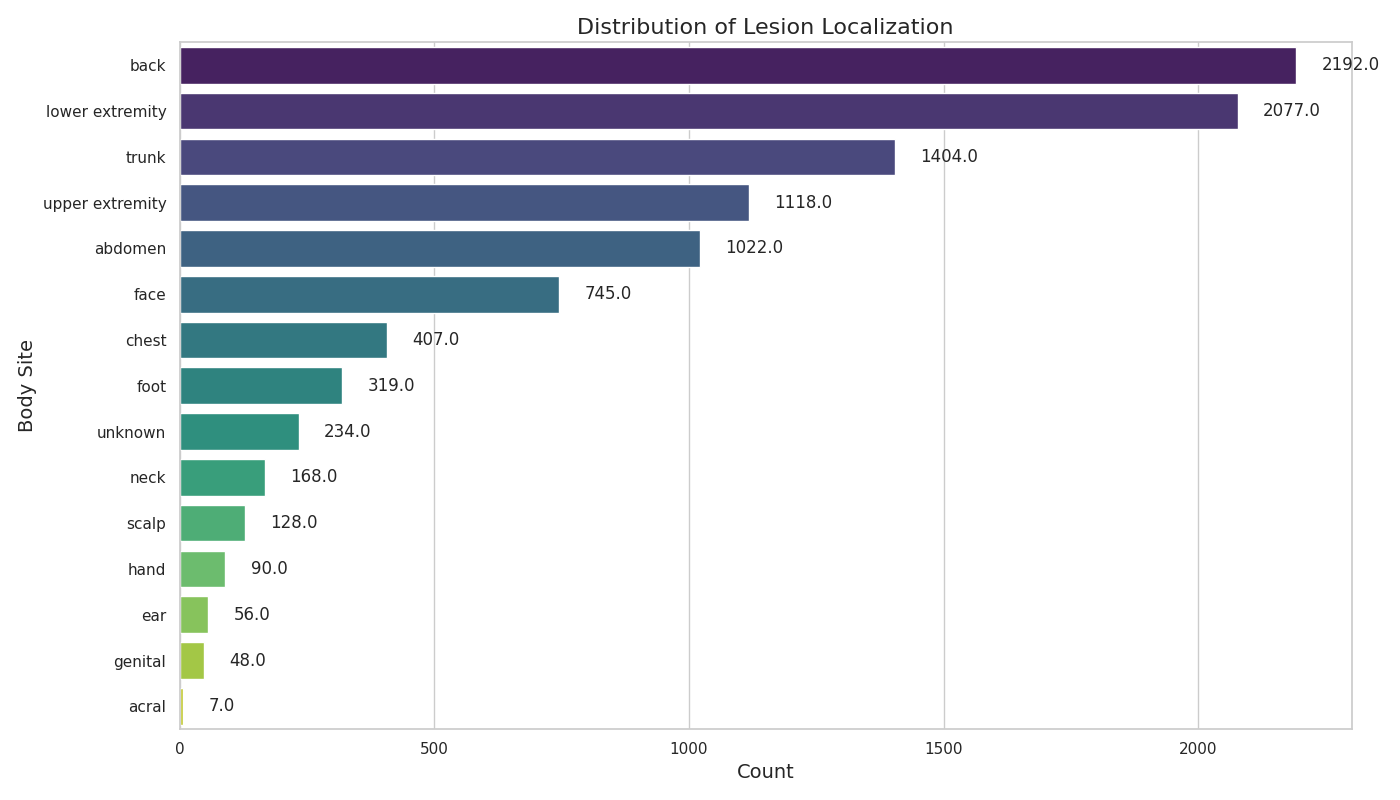

In [28]:
Image('charts/localization_distribution.png')

In [29]:
#Dataset balance analysis
print("\n15. Dataset Balance Analysis:")
total_images = len(metadata_df)

print("Class distribution in the dataset:")
for dx, count in diagnosis_counts.items():
    percentage = (count / total_images) * 100
    print(f"{dx} ({diagnosis_mapping[dx]}): {count} images ({percentage:.2f}%)")
    
# Create a pie chart for class distribution
plt.figure(figsize=(12, 10))
plt.pie(diagnosis_counts, labels=[f"{dx} - {diagnosis_mapping[dx]}" for dx in diagnosis_counts.index], 
        autopct='%1.1f%%', colors=sns.color_palette('viridis', len(diagnosis_counts)), 
        startangle=90, explode=[0.05] * len(diagnosis_counts))
plt.title('Class Distribution in HAM10000 Dataset', fontsize=16)
plt.tight_layout()
plt.savefig('charts/class_distribution_pie.png')
plt.close()


15. Dataset Balance Analysis:
Class distribution in the dataset:
nv (Melanocytic Nevi): 6705 images (66.95%)
mel (Melanoma): 1113 images (11.11%)
bkl (Benign Keratosis-like Lesions): 1099 images (10.97%)
bcc (Basal Cell Carcinoma): 514 images (5.13%)
akiec (Actinic Keratoses and Intraepithelial Carcinoma): 327 images (3.27%)
vasc (Vascular Lesions): 142 images (1.42%)
df (Dermatofibroma): 115 images (1.15%)


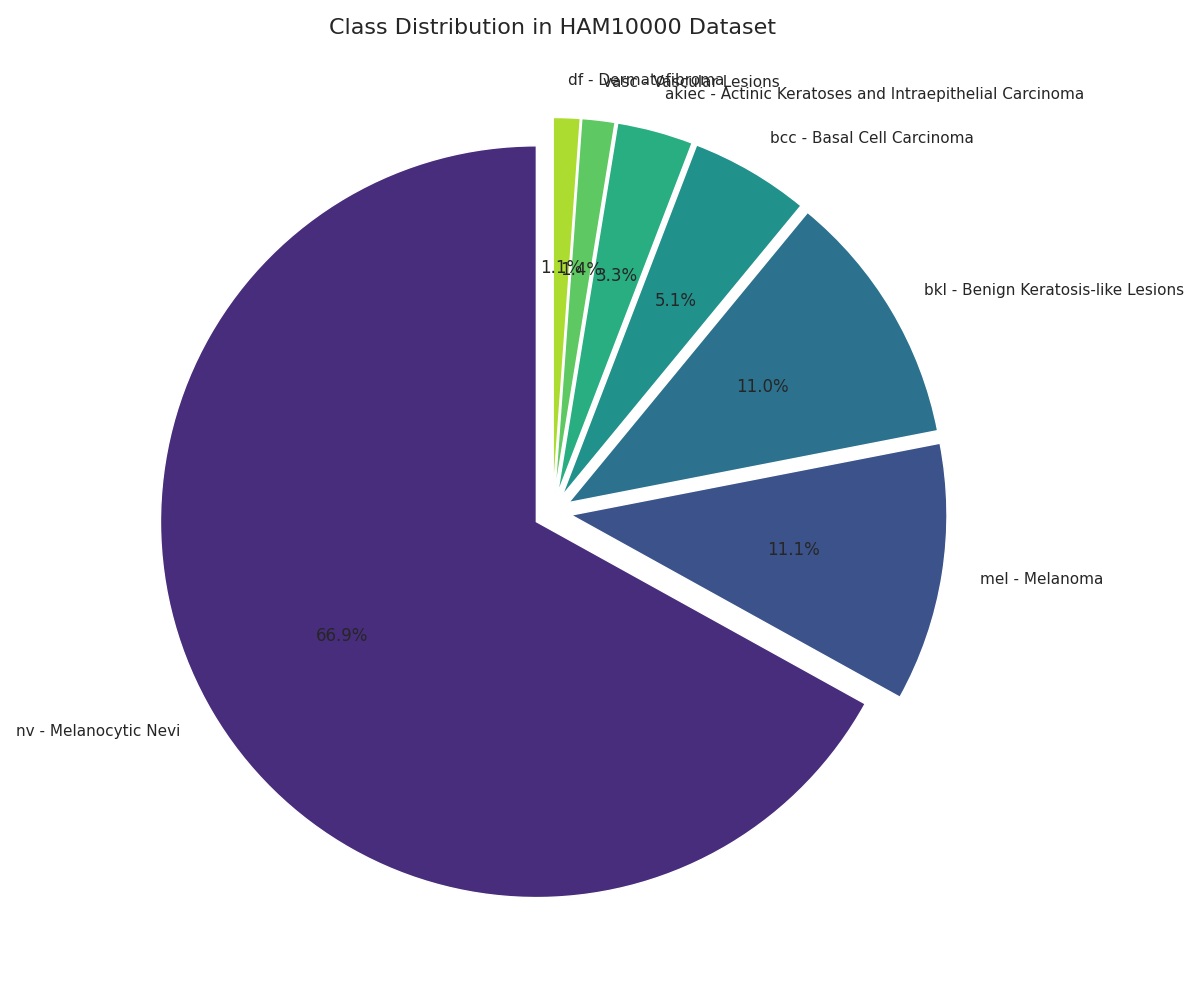

In [30]:
Image('charts/class_distribution_pie.png')

In [31]:
#  Randomly display one image from each class in the HAM10000 dataset
import random
random.seed(42)

dataset_path = "data"

# Check if the metadata file exists
metadata_path = os.path.join(dataset_path, 'HAM10000_metadata.csv')
if not os.path.exists(metadata_path):
    print(f"Error: Metadata file not found at {metadata_path}")

# Load metadata
print("Loading metadata...")
metadata_df = pd.read_csv(metadata_path)
print(metadata_df.head())

image_dir = os.path.join(dataset_path, 'ISIC2018_Task3_Training_Input')

if image_dir is None:
    print("Error: Could not find image directory. Please check the dataset structure.")

Loading metadata...
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  



Randomly selecting and displaying one image from each class...
Displayed bkl image: ISIC_0026378.jpg
Image shape: (450, 600, 3)
Displayed nv image: ISIC_0024326.jpg
Image shape: (450, 600, 3)
Displayed df image: ISIC_0032247.jpg
Image shape: (450, 600, 3)
Displayed mel image: ISIC_0031494.jpg
Image shape: (450, 600, 3)
Displayed vasc image: ISIC_0025425.jpg
Image shape: (450, 600, 3)
Displayed bcc image: ISIC_0027546.jpg
Image shape: (450, 600, 3)
Displayed akiec image: ISIC_0027334.jpg
Image shape: (450, 600, 3)


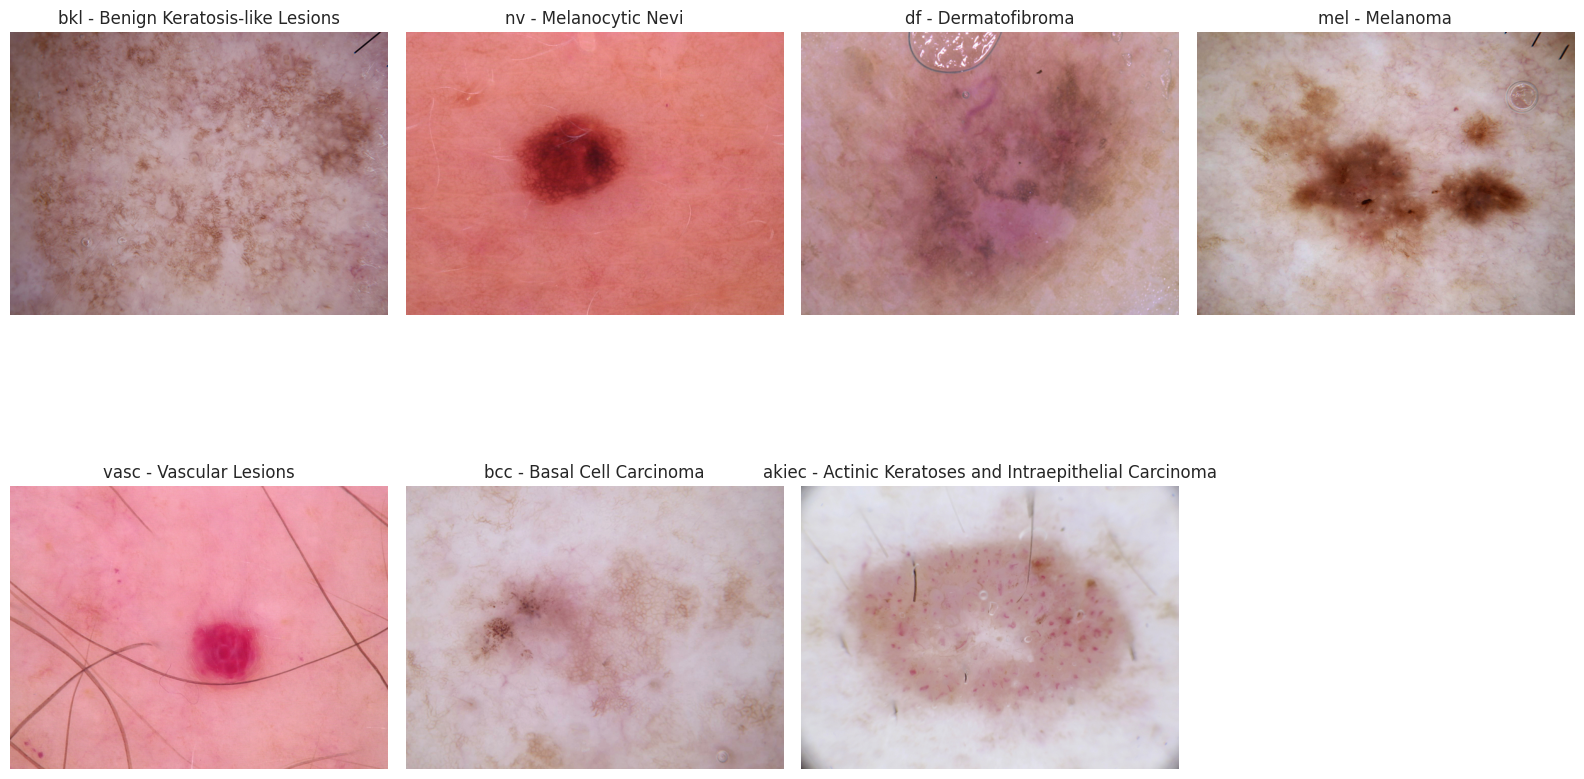

In [35]:
# Get unique diagnoses
diagnoses = metadata_df['dx'].unique()

# Create a figure to display one image from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

print("\nRandomly selecting and displaying one image from each class...")

for i, diagnosis in enumerate(diagnoses):
    # Get all image IDs for this diagnosis
    diagnosis_images = metadata_df[metadata_df['dx'] == diagnosis]['image_id'].values
    
    # Randomly select one image
    random_image_id = np.random.choice(diagnosis_images)
    
    # Find the image file path (check for common extensions)
    image_path = None
    path = os.path.join(image_dir, random_image_id + '.jpg')
    if os.path.exists(path):
        image_path = path
    
    # If image not found in main directory, check if there are subdirectories
    if image_path is None:
        for subdir in os.listdir(image_dir):
            subdir_path = os.path.join(image_dir, subdir)
            if os.path.isdir(subdir_path):
                path = os.path.join(subdir_path, random_image_id + '.jpg')
                if os.path.exists(path):
                    image_path = path
                    break
    
    if image_path is None:
        print(f"Warning: Could not find image file for ID {random_image_id} (diagnosis: {diagnosis})")
        continue
    
    # Load and display the image
    try:
        img = Img.open(image_path)  # Changed from Img to Image
        axes[i].imshow(img)
        axes[i].set_title(f"{diagnosis} - {diagnosis_mapping[diagnosis]}")
        axes[i].axis('off')
        print(f"Displayed {diagnosis} image: {os.path.basename(image_path)}")
        print(f"Image shape: {np.asarray(img).shape}")
    except Exception as e:
        print(f"Error displaying image {image_path}: {str(e)}")

# If there are fewer than 8 classes, remove empty subplots
for j in range(len(diagnoses), len(axes)):
    if j < len(axes):  # Safety check
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()